# Import Libraries and files

In [4]:
from ultralytics import YOLO
import numpy as np
import json
import matplotlib.pyplot as plt
import tifffile
import matplotlib.patches as patches
from PIL import Image
import time
from pathlib import Path

# Plot function and Dataset processing function

In [45]:
def plot_images_with_bboxes(image, predicted, bboxes_labels):

    # Read and draw the bounding2 boxes
    #bboxes = sample_info['rocks_annotations']  # Assuming each image has a 'annotations' field containing the bounding boxes

    #  Open and display the image
    image_rgb = tifffile.imread("test_images/RGB/" + image + '.tif')
    image_3D = tifffile.imread("test_images/S3D/" + image + '.tif')
    pred = Image.open(predicted)
    pred_RGB = Image.open(predicted.replace('predict','predict2'))
    
    f, ax = plt.subplots(1,4)
    f.set_figheight(15)
    f.set_figwidth(15)
    ax[0].imshow(image_rgb)
    ax[0].axis('off')
    ax[0].title.set_text('RGB swissIMAGE labels')
    bboxes_labels = str(bboxes_labels).split('\n')

    for boxes in bboxes_labels:
        if not(boxes == ''):
            boxes = boxes.split(' ')
            x,y = int(float(boxes[1])*640), int(float(boxes[2])*640)
            rect = patches.Circle((x, y), radius=20,  linewidth=2, edgecolor='r', facecolor='none')
            ax[0].add_patch(rect)
        
    ax[1].imshow(image_3D)
    ax[1].axis('off')
    ax[1].title.set_text('Surface 3D image')

    
    ax[2].imshow(pred)
    ax[2].axis('off')
    ax[2].title.set_text('Best model predicted rocks')
    
    ax[3].imshow(pred_RGB)
    ax[3].axis('off')
    ax[3].title.set_text('RGB model predicted rocks')
    


def process_data(images):
    images = [np.log1p(img) for img in images]                                                    # Apply log scale
    images = [(((img - img.min())/(img.max()-img.min()))*255).astype(np.uint8) for img in images] # Normalize images
    images = [np.stack([img] * 3, axis=-1) for img in images]                                     # Adds two channels so YOLO can read them

    return images
    

# Inference of best morel on 3 random images


0: 640x640 10 rocks, 64.2ms
1: 640x640 16 rocks, 64.2ms
2: 640x640 1 rock, 64.2ms
3: 640x640 (no detections), 64.2ms
Speed: 2.6ms preprocess, 64.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to 20250114-150801\predict

0: 640x640 53 rocks, 4.5ms
1: 640x640 16 rocks, 4.5ms
2: 640x640 1 rock, 4.5ms
3: 640x640 (no detections), 4.5ms
Speed: 1.2ms preprocess, 4.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to 20250114-150801\predict2


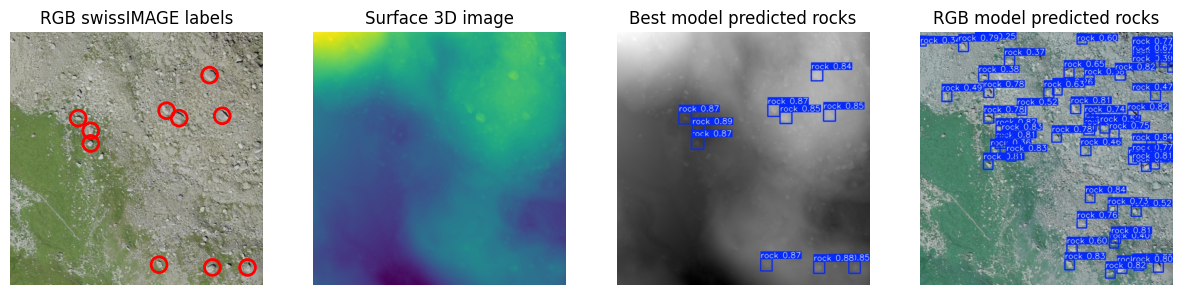

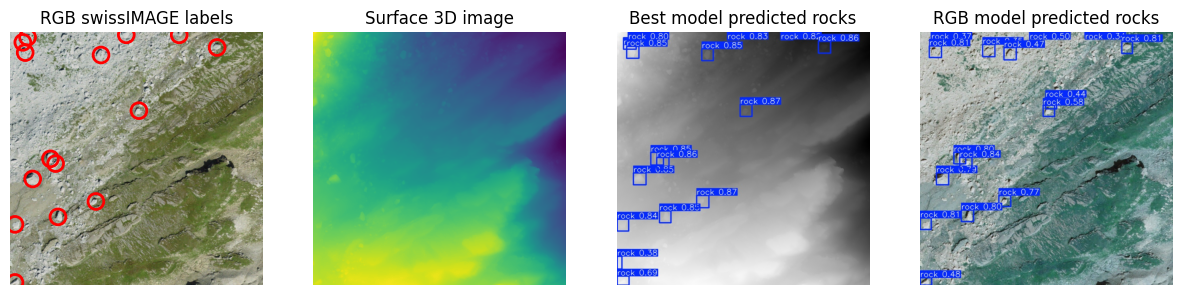

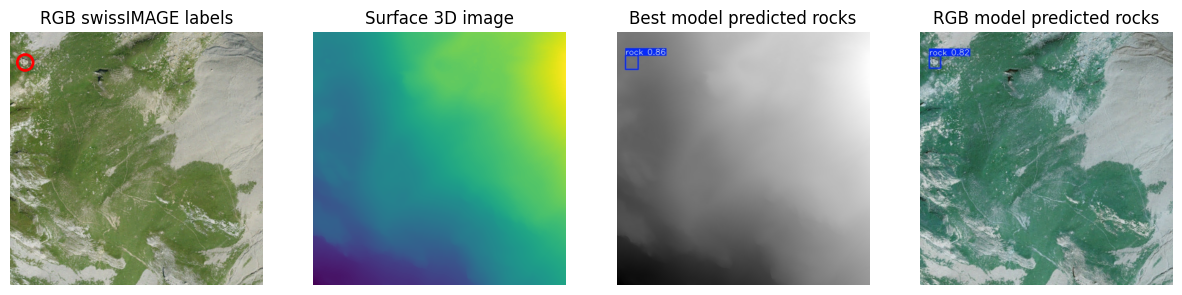

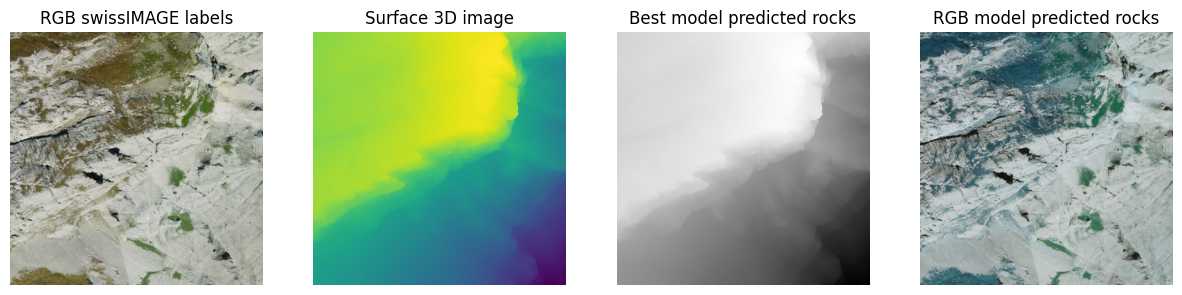

In [48]:
%matplotlib inline

NUM_IMAGES = 2                                # Number of images to predict at once
USE_GPU = False                               # Set to True if you want to use GPU (make sure you have the right drivers)
json_file_path = "large_rock_dataset.json"    # JSON dataseet file


model = YOLO('models/best_model_3D.pt')       # Model trained on the Surface 3D dataset
model_RGB = YOLO('models/best_model_RGB.pt')  # Model trained on the RGB dataset


image_files = ['2581_1126_1_1', '2587_1132_0_0', '2595_1130_0_2', '2597_1132_0_3']

if USE_GPU:
    model.to('cuda')
    model_RGB.to('cuda')

# Time for name
time_str = f'{time.strftime("%Y%m%d-%H%M%S")}'

images = [tifffile.imread('test_images/S3D/' + image + '.tif') for image in image_files]          # Save images in array
images_RGB = [tifffile.imread('test_images/RGB/' + image + '.tif') for image in image_files] 


images = process_data(images)                                                   # Apply data processing function

results = model(images , save=True, project=time_str)
results_2 = model_RGB(images_RGB , save=True, project=time_str)

annotations = [open(f'test_images/Labels/{img}.txt').read() for img in image_files]

idx=0
for img in image_files:
    plot_images_with_bboxes(img, f'{time_str}/predict/' + f'image{idx}.jpg' , annotations[idx])
    idx+=1
plt.show()